# Climate Projection for Next the 100 Years

In [22]:
# import all nessary libearies
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime, timedelta
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_absolute_error, r2_score
from fbprophet import Prophet

In [2]:
%matplotlib inline

#### Load and explore data

In [4]:
precip = pd.read_excel("climate_data/merged_precip.xlsx")

In [5]:
precip.head()

,Year,Country,Precipitation
0,1901-01-01,Brazil,1763.85
1,1901-01-01,United Kingdom,995.77
2,1901-01-01,Bangladesh,2403.13
3,1901-01-01,Iceland,917.71
4,1901-01-01,Saudi Arabia,77.98


In [6]:
temp = pd.read_excel("climate_data/merged_temp.xlsx")

In [7]:
temp.head()

,Year,Country,Temperature
0,1901-01-01,Algeria,22.58
1,1902-01-01,Algeria,22.58
2,1903-01-01,Algeria,22.48
3,1904-01-01,Algeria,22.65
4,1905-01-01,Algeria,22.43


#### merge temperature and precipitation in one dataframe

In [9]:
merged = precip.merge(temp, left_on=['Year', 'Country'], right_on=['Year', 'Country'])

In [10]:
# check average temperature for 2020
merged[merged['Year'] == '2020-01-01']['Temperature'].mean()

13.691176470588236

In [11]:
merged.dtypes

Year             datetime64[ns]
Country                  object
Precipitation           float64
Temperature             float64
dtype: object

In [12]:
merged.describe()

,Precipitation,Temperature
count,2040.000000,2040.000000
mean,801.743618,12.730603
std,604.880388,12.606869
min,20.890000,-18.010000
25%,460.470000,6.477500
50%,623.375000,14.600000
75%,1104.707500,24.372500
max,2923.740000,26.510000


In [13]:
merged.isnull().sum()

Year             0
Country          0
Precipitation    0
Temperature      0
dtype: int64

In [14]:
merged.shape

(2040, 4)

In [15]:
merged.head()

,Year,Country,Precipitation,Temperature
0,1901-01-01,Brazil,1763.85,25.04
1,1901-01-01,United Kingdom,995.77,8.07
2,1901-01-01,Bangladesh,2403.13,25.09
3,1901-01-01,Iceland,917.71,1.60
4,1901-01-01,Saudi Arabia,77.98,24.75


In [16]:
# group by country
grouped = merged[["Year","Country", "Temperature", "Precipitation"]].groupby(["Country"])

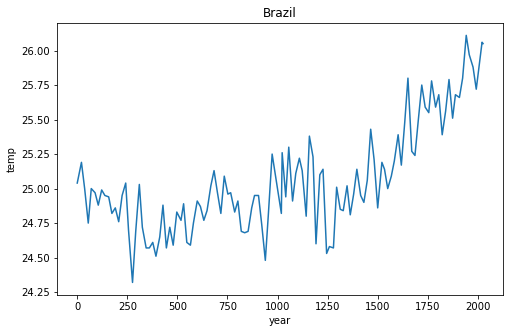

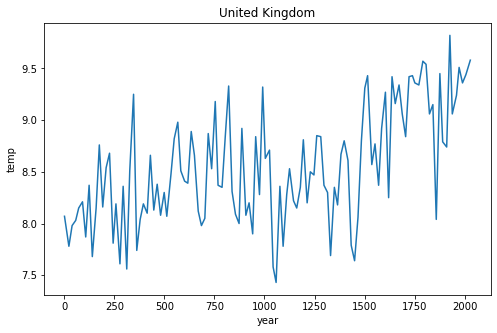

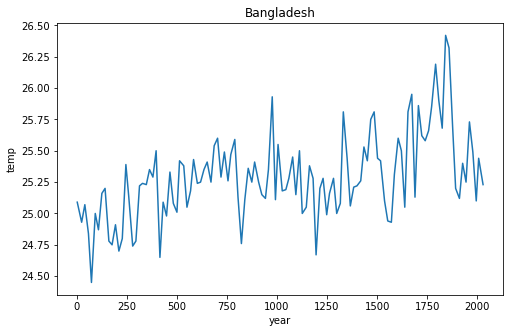

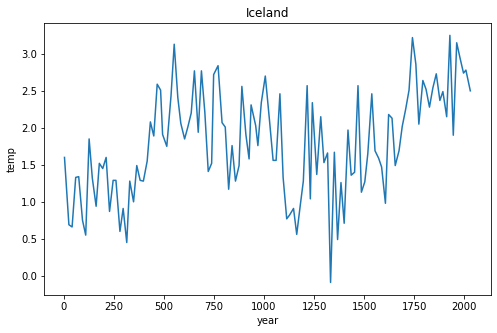

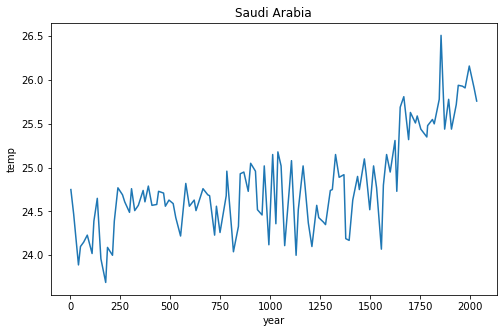

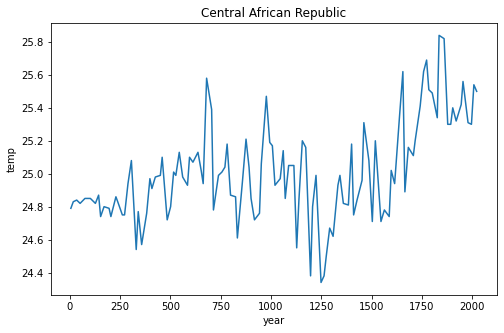

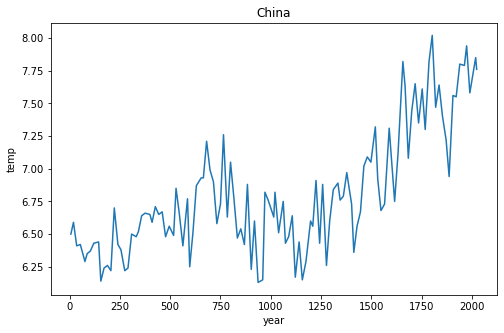

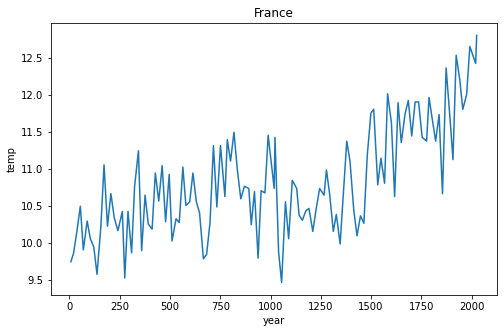

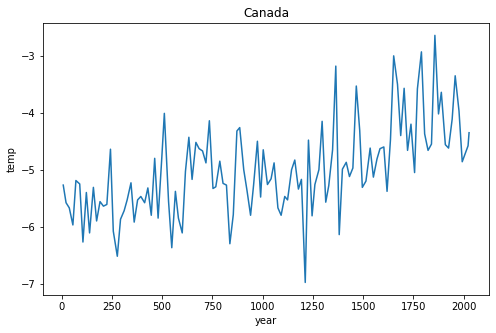

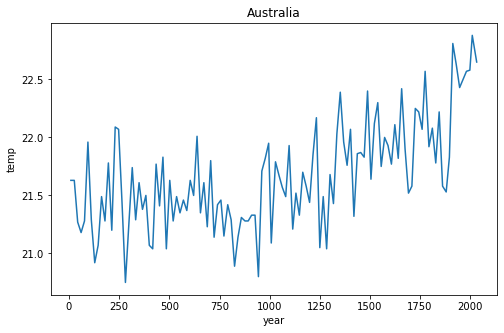

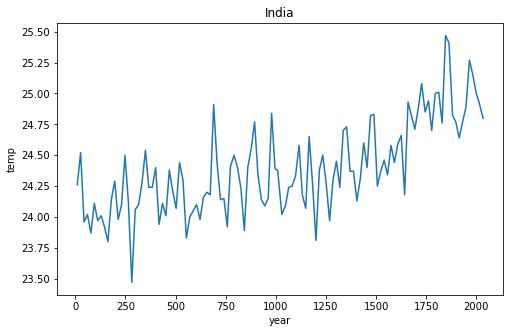

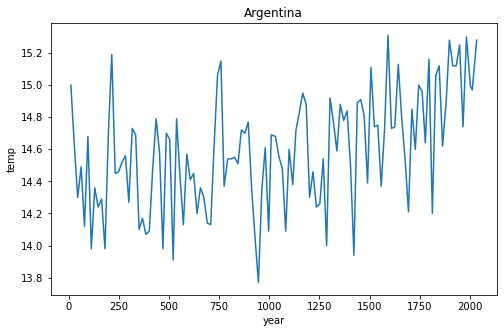

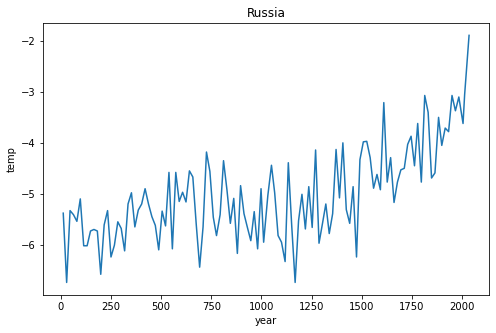

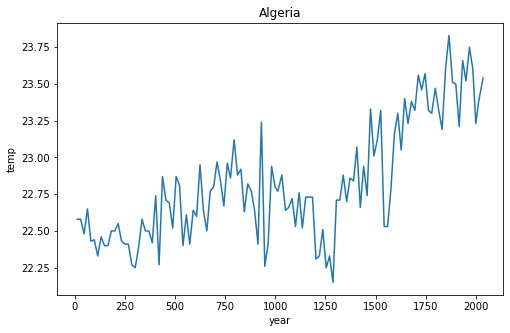

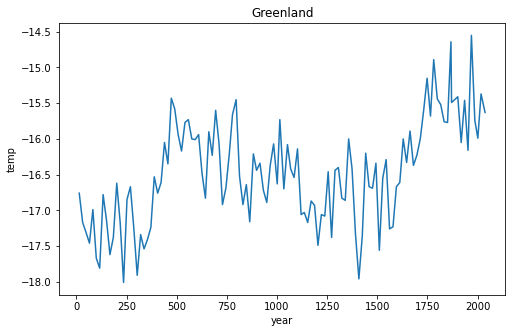

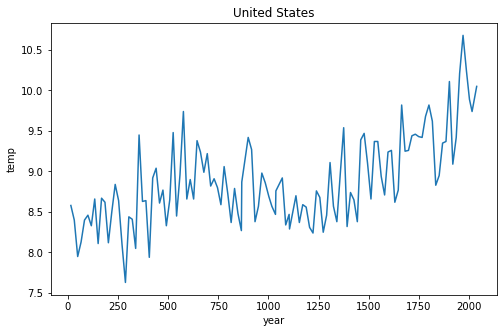

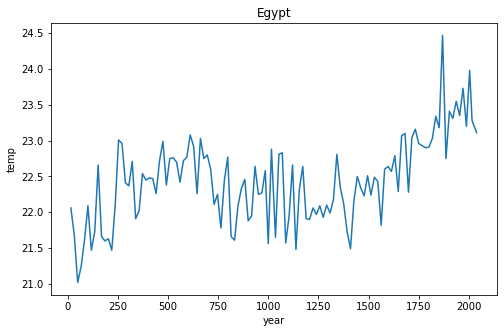

In [17]:
# plot temperatures per country
countries = merged["Country"].unique()
for country in countries:
    plt.figure(figsize=(8,5))
    plt.plot(merged.query(f'Country == "{country}"')[["Temperature"]])
    plt.title(country)
    plt.xlabel("year")
    plt.ylabel("temp")
    plt.show()

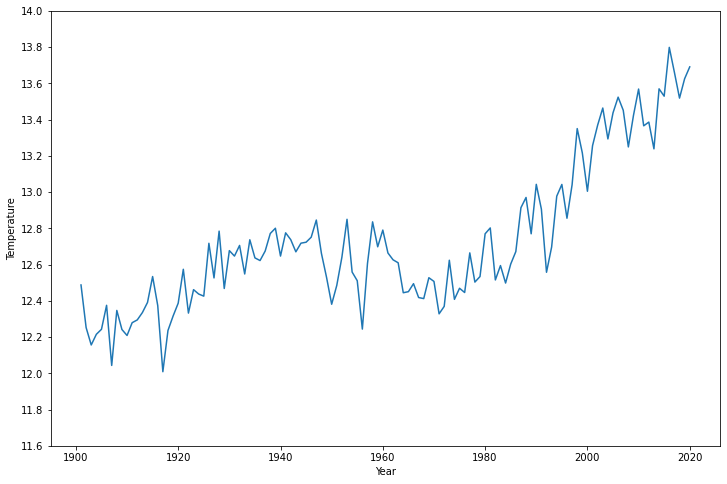

In [18]:
# Average global temperature
plt.figure(figsize=(12,8))
sns.lineplot(x='Year', y='Temperature', data=merged, ci=None, markers=True)
plt.yticks([11.6, 11.8, 12, 12.2, 12.4, 12.6, 12.8, 13, 13.2, 13.4, 13.6, 13.8, 14])
plt.show()

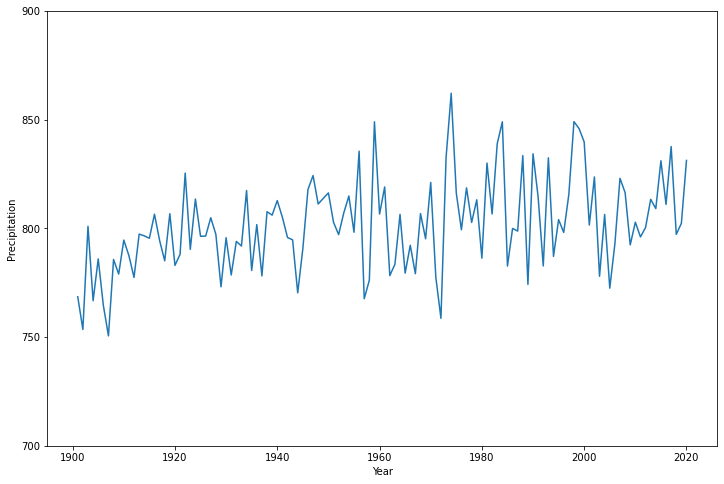

In [19]:
# Average global precipitation
plt.figure(figsize=(12,8))
sns.lineplot(x='Year', y='Precipitation', data=merged, ci=None, markers=True)
plt.yticks([700, 750, 800, 850, 900])
plt.show()

In [21]:
for country in grouped.groups:
    c = grouped.get_group(country)
    print(c)
    break

           Year  Country  Temperature  Precipitation
13   1901-01-01  Algeria        22.58         102.86
30   1902-01-01  Algeria        22.58          91.50
47   1903-01-01  Algeria        22.48          73.28
64   1904-01-01  Algeria        22.65         105.60
81   1905-01-01  Algeria        22.43          87.81
...         ...      ...          ...            ...
1968 2016-01-01  Algeria        23.75          64.49
1985 2017-01-01  Algeria        23.60          68.88
2000 2018-01-01  Algeria        23.23          88.24
2014 2019-01-01  Algeria        23.38          70.91
2036 2020-01-01  Algeria        23.54          55.42

[120 rows x 4 columns]


In [21]:
# Determine how stationary data is for each country
for country in grouped.groups:
    group = grouped.get_group(country)
    print(f"Dickey-Fuller Test {country} Temperature")
    test_df = adfuller(group.iloc[:,2].values, autolag='AIC')
    df_output = pd.Series(test_df[0:4], index=["Test Statistic", "p-value", "Lags Used", "Number of observations used"])
    for key, value in test_df[4].items():
        df_output[f'Critical value ({key})'] = value
    print(df_output)
    
    print(f"Dickey-Fuller Test {country} Precipitation")
    test_df = adfuller(group.iloc[:,3].values, autolag='AIC')
    df_output = pd.Series(test_df[0:4], index=["Test Statistic", "p-value", "Lags Used", "Number of observations used"])
    for key, value in test_df[4].items():
        df_output[f'Critical value ({key})'] = value
    print(df_output)
    print("*********************************************************************************************************")


Dickey-Fuller Test Algeria Temperature
Test Statistic                  -1.028649
p-value                          0.742672
Lags Used                        3.000000
Number of observations used    116.000000
Critical value (1%)             -3.488022
Critical value (5%)             -2.886797
Critical value (10%)            -2.580241
dtype: float64
Dickey-Fuller Test Algeria Precipitation
Test Statistic                -1.103396e+01
p-value                        5.577585e-20
Lags Used                      0.000000e+00
Number of observations used    1.190000e+02
Critical value (1%)           -3.486535e+00
Critical value (5%)           -2.886151e+00
Critical value (10%)          -2.579896e+00
dtype: float64
*********************************************************************************************************
Dickey-Fuller Test Argentina Temperature
Test Statistic                  -1.034423
p-value                          0.740503
Lags Used                        7.000000
Number of obser

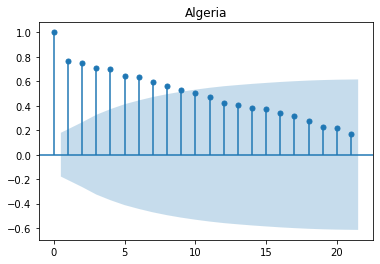

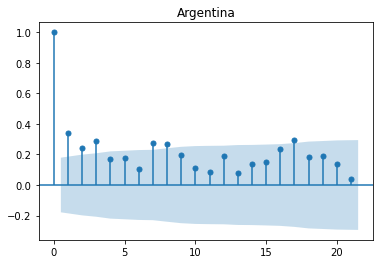

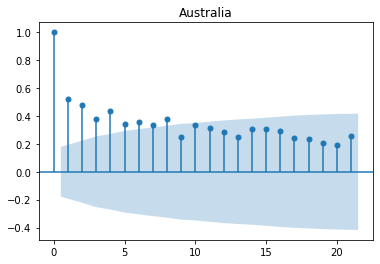

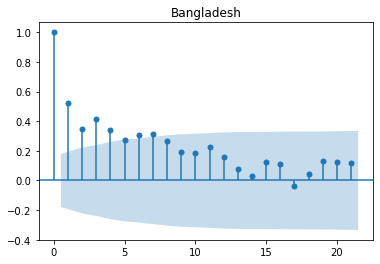

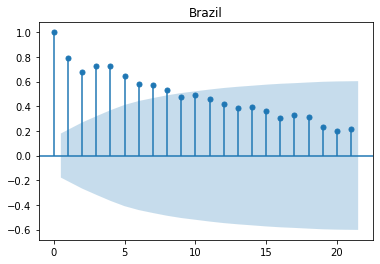

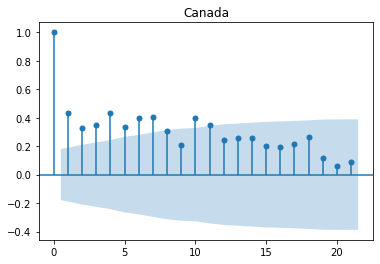

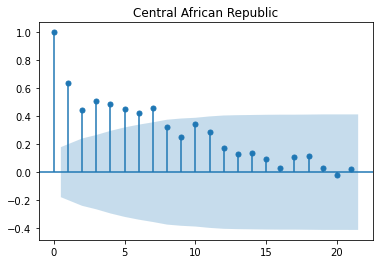

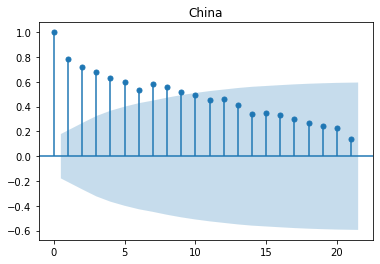

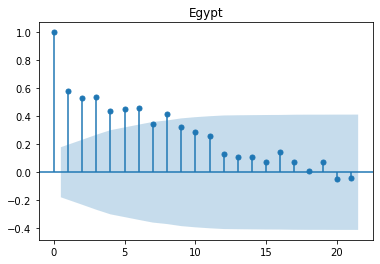

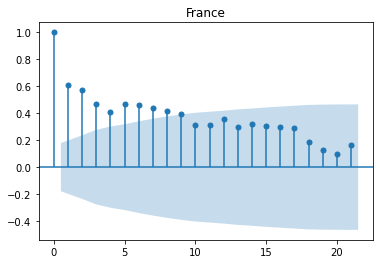

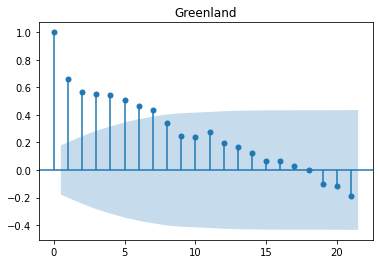

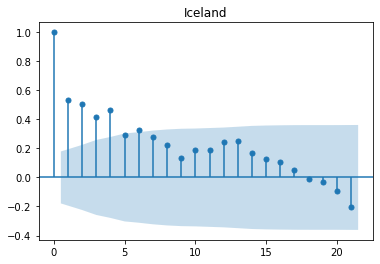

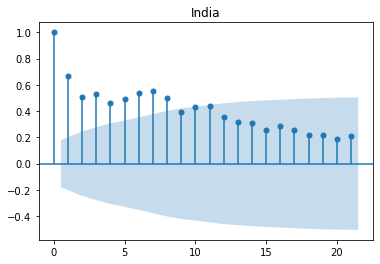

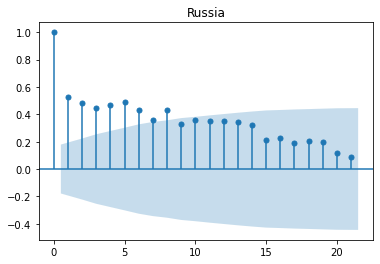

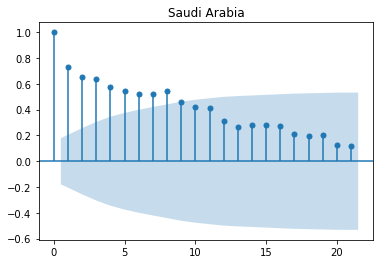

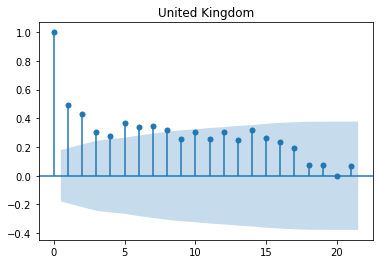

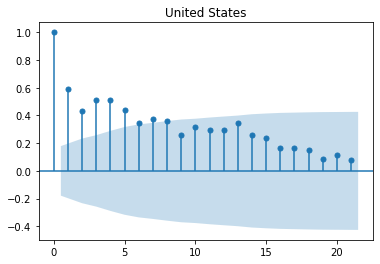

In [23]:
for country in grouped.groups:
    c = grouped.get_group(country)
    plot_acf(c['Temperature'])
    plt.title(country)
    plt.show()

#### Split data for train and test. train -> 1901 - 2015, test -> 2016-2020

In [24]:
# # train test split
train = pd.DataFrame()
test = pd.DataFrame()

for country in grouped.groups:
    c = grouped.get_group(country)
    tr = c[(c['Year'] <= '2015-01-01')]
    ts = c[(c['Year'] > '2015-01-01')]
    train = pd.concat([train, tr])
    test = pd.concat([test, ts])
print(train.shape, test.shape)

(1955, 4) (85, 4)


In [26]:
test

,Year,Country,Temperature,Precipitation
1968,2016-01-01,Algeria,23.75,64.49
1985,2017-01-01,Algeria,23.60,68.88
2000,2018-01-01,Algeria,23.23,88.24
2014,2019-01-01,Algeria,23.38,70.91
2036,2020-01-01,Algeria,23.54,55.42
...,...,...,...,...
1970,2016-01-01,United States,10.68,728.29
1987,2017-01-01,United States,10.24,755.19
2002,2018-01-01,United States,9.89,804.40
2015,2019-01-01,United States,9.74,814.96


### Train and predict

In [27]:
target_test = pd.DataFrame()
cols = ['Temperature', 'Precipitation']

tr_gr = train[["Year","Country", "Temperature", "Precipitation"]].groupby(["Country"])
for country in tr_gr.groups:
    c = tr_gr.get_group(country)
    for col in cols:
        temp = c.rename(columns={"Year": "ds", 'Country': "Country", col:'y'})
        print(temp)
        m = Prophet()
        # train model
        m.fit(temp)
        # make forecast for next years
        future = m.make_future_dataframe(periods=6, freq='Y')
        forecast = m.predict(future)
        #     m.plot(forecast)
        # rename column , so it won't be ovewriten by next city
        forecast = forecast.rename(columns={'yhat': f'{country}_{col}'})
        target_test = pd.merge(target_test, forecast.set_index('ds')[f'{country}_{col}'], how='outer', left_index=True, right_index=True)
    

             ds  Country      y  Precipitation
13   1901-01-01  Algeria  22.58         102.86
30   1902-01-01  Algeria  22.58          91.50
47   1903-01-01  Algeria  22.48          73.28
64   1904-01-01  Algeria  22.65         105.60
81   1905-01-01  Algeria  22.43          87.81
...         ...      ...    ...            ...
1884 2011-01-01  Algeria  23.51          91.53
1900 2012-01-01  Algeria  23.50          79.14
1917 2013-01-01  Algeria  23.21          84.10
1934 2014-01-01  Algeria  23.66          70.94
1951 2015-01-01  Algeria  23.52          71.75

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds  Country  Temperature       y
13   1901-01-01  Algeria        22.58  102.86
30   1902-01-01  Algeria        22.58   91.50
47   1903-01-01  Algeria        22.48   73.28
64   1904-01-01  Algeria        22.65  105.60
81   1905-01-01  Algeria        22.43   87.81
...         ...      ...          ...     ...
1884 2011-01-01  Algeria        23.51   91.53
1900 2012-01-01  Algeria        23.50   79.14
1917 2013-01-01  Algeria        23.21   84.10
1934 2014-01-01  Algeria        23.66   70.94
1951 2015-01-01  Algeria        23.52   71.75

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds    Country      y  Precipitation
11   1901-01-01  Argentina  15.00         439.65
28   1902-01-01  Argentina  14.63         495.48
45   1903-01-01  Argentina  14.30         540.98
62   1904-01-01  Argentina  14.49         557.03
79   1905-01-01  Argentina  14.12         538.47
...         ...        ...    ...            ...
1882 2011-01-01  Argentina  14.90         536.49
1898 2012-01-01  Argentina  15.28         596.11
1915 2013-01-01  Argentina  15.12         498.35
1932 2014-01-01  Argentina  15.12         674.32
1949 2015-01-01  Argentina  15.25         622.12

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds    Country  Temperature       y
11   1901-01-01  Argentina        15.00  439.65
28   1902-01-01  Argentina        14.63  495.48
45   1903-01-01  Argentina        14.30  540.98
62   1904-01-01  Argentina        14.49  557.03
79   1905-01-01  Argentina        14.12  538.47
...         ...        ...          ...     ...
1882 2011-01-01  Argentina        14.90  536.49
1898 2012-01-01  Argentina        15.28  596.11
1915 2013-01-01  Argentina        15.12  498.35
1932 2014-01-01  Argentina        15.12  674.32
1949 2015-01-01  Argentina        15.25  622.12

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds    Country      y  Precipitation
9    1901-01-01  Australia  21.63         428.00
26   1902-01-01  Australia  21.63         321.23
43   1903-01-01  Australia  21.27         527.82
60   1904-01-01  Australia  21.18         496.03
77   1905-01-01  Australia  21.28         360.00
...         ...        ...    ...            ...
1880 2011-01-01  Australia  21.53         563.14
1896 2012-01-01  Australia  21.83         470.49
1913 2013-01-01  Australia  22.81         443.93
1930 2014-01-01  Australia  22.63         462.17
1947 2015-01-01  Australia  22.43         452.05

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds    Country  Temperature       y
9    1901-01-01  Australia        21.63  428.00
26   1902-01-01  Australia        21.63  321.23
43   1903-01-01  Australia        21.27  527.82
60   1904-01-01  Australia        21.18  496.03
77   1905-01-01  Australia        21.28  360.00
...         ...        ...          ...     ...
1880 2011-01-01  Australia        21.53  563.14
1896 2012-01-01  Australia        21.83  470.49
1913 2013-01-01  Australia        22.81  443.93
1930 2014-01-01  Australia        22.63  462.17
1947 2015-01-01  Australia        22.43  452.05

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds     Country      y  Precipitation
2    1901-01-01  Bangladesh  25.09        2403.13
24   1902-01-01  Bangladesh  24.93        2357.41
40   1903-01-01  Bangladesh  25.07        2293.01
58   1904-01-01  Bangladesh  24.84        2396.89
73   1905-01-01  Bangladesh  24.45        2705.51
...         ...         ...    ...            ...
1877 2011-01-01  Bangladesh  25.69        1971.04
1892 2012-01-01  Bangladesh  25.20        1992.35
1911 2013-01-01  Bangladesh  25.12        2023.31
1927 2014-01-01  Bangladesh  25.40        1801.96
1944 2015-01-01  Bangladesh  25.25        2543.25

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds     Country  Temperature        y
2    1901-01-01  Bangladesh        25.09  2403.13
24   1902-01-01  Bangladesh        24.93  2357.41
40   1903-01-01  Bangladesh        25.07  2293.01
58   1904-01-01  Bangladesh        24.84  2396.89
73   1905-01-01  Bangladesh        24.45  2705.51
...         ...         ...          ...      ...
1877 2011-01-01  Bangladesh        25.69  1971.04
1892 2012-01-01  Bangladesh        25.20  1992.35
1911 2013-01-01  Bangladesh        25.12  2023.31
1927 2014-01-01  Bangladesh        25.40  1801.96
1944 2015-01-01  Bangladesh        25.25  2543.25

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country      y  Precipitation
0    1901-01-01  Brazil  25.04        1763.85
21   1902-01-01  Brazil  25.19        1753.66
37   1903-01-01  Brazil  25.00        1725.01
55   1904-01-01  Brazil  24.75        1726.37
70   1905-01-01  Brazil  25.00        1757.17
...         ...     ...    ...            ...
1874 2011-01-01  Brazil  25.51        1836.31
1888 2012-01-01  Brazil  25.68        1675.27
1908 2013-01-01  Brazil  25.66        1797.92
1924 2014-01-01  Brazil  25.80        1745.69
1942 2015-01-01  Brazil  26.11        1621.71

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country  Temperature        y
0    1901-01-01  Brazil        25.04  1763.85
21   1902-01-01  Brazil        25.19  1753.66
37   1903-01-01  Brazil        25.00  1725.01
55   1904-01-01  Brazil        24.75  1726.37
70   1905-01-01  Brazil        25.00  1757.17
...         ...     ...          ...      ...
1874 2011-01-01  Brazil        25.51  1836.31
1888 2012-01-01  Brazil        25.68  1675.27
1908 2013-01-01  Brazil        25.66  1797.92
1924 2014-01-01  Brazil        25.80  1745.69
1942 2015-01-01  Brazil        26.11  1621.71

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country     y  Precipitation
8    1901-01-01  Canada -5.27         521.09
22   1902-01-01  Canada -5.58         531.63
38   1903-01-01  Canada -5.67         522.74
56   1904-01-01  Canada -5.97         514.83
71   1905-01-01  Canada -5.19         514.23
...         ...     ...   ...            ...
1875 2011-01-01  Canada -4.02         536.00
1889 2012-01-01  Canada -3.64         524.81
1909 2013-01-01  Canada -4.56         526.41
1925 2014-01-01  Canada -4.62         539.59
1943 2015-01-01  Canada -4.11         515.88

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country  Temperature       y
8    1901-01-01  Canada        -5.27  521.09
22   1902-01-01  Canada        -5.58  531.63
38   1903-01-01  Canada        -5.67  522.74
56   1904-01-01  Canada        -5.97  514.83
71   1905-01-01  Canada        -5.19  514.23
...         ...     ...          ...     ...
1875 2011-01-01  Canada        -4.02  536.00
1889 2012-01-01  Canada        -3.64  524.81
1909 2013-01-01  Canada        -4.56  526.41
1925 2014-01-01  Canada        -4.62  539.59
1943 2015-01-01  Canada        -4.11  515.88

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds                   Country      y  Precipitation
5    1901-01-01  Central African Republic  24.79        1358.57
17   1902-01-01  Central African Republic  24.83        1358.57
34   1903-01-01  Central African Republic  24.84        1358.57
51   1904-01-01  Central African Republic  24.82        1342.98
75   1905-01-01  Central African Republic  24.85        1348.37
...         ...                       ...    ...            ...
1879 2011-01-01  Central African Republic  25.30        1362.26
1894 2012-01-01  Central African Republic  25.30        1404.46
1904 2013-01-01  Central African Republic  25.40        1416.41
1921 2014-01-01  Central African Republic  25.32        1357.58
1946 2015-01-01  Central African Republic  25.42        1361.02

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds                   Country  Temperature        y
5    1901-01-01  Central African Republic        24.79  1358.57
17   1902-01-01  Central African Republic        24.83  1358.57
34   1903-01-01  Central African Republic        24.84  1358.57
51   1904-01-01  Central African Republic        24.82  1342.98
75   1905-01-01  Central African Republic        24.85  1348.37
...         ...                       ...          ...      ...
1879 2011-01-01  Central African Republic        25.30  1362.26
1894 2012-01-01  Central African Republic        25.30  1404.46
1904 2013-01-01  Central African Republic        25.40  1416.41
1921 2014-01-01  Central African Republic        25.32  1357.58
1946 2015-01-01  Central African Republic        25.42  1361.02

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country     y  Precipitation
6    1901-01-01   China  6.50         561.73
19   1902-01-01   China  6.59         549.38
35   1903-01-01   China  6.41         616.98
53   1904-01-01   China  6.42         591.51
76   1905-01-01   China  6.29         609.91
...         ...     ...   ...            ...
1872 2011-01-01   China  7.22         540.06
1887 2012-01-01   China  6.94         640.01
1906 2013-01-01   China  7.56         615.57
1922 2014-01-01   China  7.55         612.21
1940 2015-01-01   China  7.80         632.39

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country  Temperature       y
6    1901-01-01   China         6.50  561.73
19   1902-01-01   China         6.59  549.38
35   1903-01-01   China         6.41  616.98
53   1904-01-01   China         6.42  591.51
76   1905-01-01   China         6.29  609.91
...         ...     ...          ...     ...
1872 2011-01-01   China         7.22  540.06
1887 2012-01-01   China         6.94  640.01
1906 2013-01-01   China         7.56  615.57
1922 2014-01-01   China         7.55  612.21
1940 2015-01-01   China         7.80  632.39

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country      y  Precipitation
16   1901-01-01   Egypt  22.06          42.90
33   1902-01-01   Egypt  21.68          38.84
50   1903-01-01   Egypt  21.02          35.38
67   1904-01-01   Egypt  21.24          45.02
84   1905-01-01   Egypt  21.61          43.03
...         ...     ...    ...            ...
1886 2011-01-01   Egypt  22.75          28.18
1903 2012-01-01   Egypt  23.41          29.69
1920 2013-01-01   Egypt  23.31          34.82
1937 2014-01-01   Egypt  23.55          35.62
1954 2015-01-01   Egypt  23.35          34.90

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country  Temperature      y
16   1901-01-01   Egypt        22.06  42.90
33   1902-01-01   Egypt        21.68  38.84
50   1903-01-01   Egypt        21.02  35.38
67   1904-01-01   Egypt        21.24  45.02
84   1905-01-01   Egypt        21.61  43.03
...         ...     ...          ...    ...
1886 2011-01-01   Egypt        22.75  28.18
1903 2012-01-01   Egypt        23.41  29.69
1920 2013-01-01   Egypt        23.31  34.82
1937 2014-01-01   Egypt        23.55  35.62
1954 2015-01-01   Egypt        23.35  34.90

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country      y  Precipitation
7    1901-01-01  France   9.75         812.84
20   1902-01-01  France   9.86         766.73
36   1903-01-01  France  10.14         799.60
54   1904-01-01  France  10.50         678.64
69   1905-01-01  France   9.91         790.02
...         ...     ...    ...            ...
1873 2011-01-01  France  12.37         721.45
1895 2012-01-01  France  11.59         863.73
1907 2013-01-01  France  11.13         942.61
1923 2014-01-01  France  12.54         926.27
1941 2015-01-01  France  12.21         707.09

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country  Temperature       y
7    1901-01-01  France         9.75  812.84
20   1902-01-01  France         9.86  766.73
36   1903-01-01  France        10.14  799.60
54   1904-01-01  France        10.50  678.64
69   1905-01-01  France         9.91  790.02
...         ...     ...          ...     ...
1873 2011-01-01  France        12.37  721.45
1895 2012-01-01  France        11.59  863.73
1907 2013-01-01  France        11.13  942.61
1923 2014-01-01  France        12.54  926.27
1941 2015-01-01  France        12.21  707.09

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds    Country      y  Precipitation
14   1901-01-01  Greenland -16.76         643.29
31   1902-01-01  Greenland -17.17         593.10
48   1903-01-01  Greenland -17.31         550.54
65   1904-01-01  Greenland -17.46         556.84
82   1905-01-01  Greenland -16.99         592.04
...         ...        ...    ...            ...
1870 2011-01-01  Greenland -15.49         607.35
1901 2012-01-01  Greenland -15.41         645.59
1918 2013-01-01  Greenland -16.05         655.51
1935 2014-01-01  Greenland -15.46         660.34
1952 2015-01-01  Greenland -16.16         685.67

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds    Country  Temperature       y
14   1901-01-01  Greenland       -16.76  643.29
31   1902-01-01  Greenland       -17.17  593.10
48   1903-01-01  Greenland       -17.31  550.54
65   1904-01-01  Greenland       -17.46  556.84
82   1905-01-01  Greenland       -16.99  592.04
...         ...        ...          ...     ...
1870 2011-01-01  Greenland       -15.49  607.35
1901 2012-01-01  Greenland       -15.41  645.59
1918 2013-01-01  Greenland       -16.05  655.51
1935 2014-01-01  Greenland       -15.46  660.34
1952 2015-01-01  Greenland       -16.16  685.67

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds  Country     y  Precipitation
3    1901-01-01  Iceland  1.60         917.71
25   1902-01-01  Iceland  0.69         824.13
41   1903-01-01  Iceland  0.66         887.25
59   1904-01-01  Iceland  1.33         965.14
74   1905-01-01  Iceland  1.34         877.24
...         ...      ...   ...            ...
1878 2011-01-01  Iceland  2.37        1280.74
1893 2012-01-01  Iceland  2.49        1086.72
1912 2013-01-01  Iceland  2.15        1150.46
1928 2014-01-01  Iceland  3.25        1239.66
1945 2015-01-01  Iceland  1.90        1180.98

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds  Country  Temperature        y
3    1901-01-01  Iceland         1.60   917.71
25   1902-01-01  Iceland         0.69   824.13
41   1903-01-01  Iceland         0.66   887.25
59   1904-01-01  Iceland         1.33   965.14
74   1905-01-01  Iceland         1.34   877.24
...         ...      ...          ...      ...
1878 2011-01-01  Iceland         2.37  1280.74
1893 2012-01-01  Iceland         2.49  1086.72
1912 2013-01-01  Iceland         2.15  1150.46
1928 2014-01-01  Iceland         3.25  1239.66
1945 2015-01-01  Iceland         1.90  1180.98

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country      y  Precipitation
10   1901-01-01   India  24.26         952.79
27   1902-01-01   India  24.52         999.69
44   1903-01-01   India  23.96        1121.12
61   1904-01-01   India  24.02         934.47
78   1905-01-01   India  23.87         915.86
...         ...     ...    ...            ...
1881 2011-01-01   India  24.82        1089.24
1897 2012-01-01   India  24.77        1018.89
1914 2013-01-01   India  24.64        1196.86
1931 2014-01-01   India  24.77         999.89
1948 2015-01-01   India  24.89        1085.10

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country  Temperature        y
10   1901-01-01   India        24.26   952.79
27   1902-01-01   India        24.52   999.69
44   1903-01-01   India        23.96  1121.12
61   1904-01-01   India        24.02   934.47
78   1905-01-01   India        23.87   915.86
...         ...     ...          ...      ...
1881 2011-01-01   India        24.82  1089.24
1897 2012-01-01   India        24.77  1018.89
1914 2013-01-01   India        24.64  1196.86
1931 2014-01-01   India        24.77   999.89
1948 2015-01-01   India        24.89  1085.10

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country     y  Precipitation
12   1901-01-01  Russia -5.38         410.33
29   1902-01-01  Russia -6.74         433.31
46   1903-01-01  Russia -5.33         434.62
63   1904-01-01  Russia -5.41         425.32
80   1905-01-01  Russia -5.54         440.78
...         ...     ...   ...            ...
1883 2011-01-01  Russia -3.50         457.14
1899 2012-01-01  Russia -4.05         473.59
1916 2013-01-01  Russia -3.71         493.81
1933 2014-01-01  Russia -3.78         462.70
1950 2015-01-01  Russia -3.07         474.77

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds Country  Temperature       y
12   1901-01-01  Russia        -5.38  410.33
29   1902-01-01  Russia        -6.74  433.31
46   1903-01-01  Russia        -5.33  434.62
63   1904-01-01  Russia        -5.41  425.32
80   1905-01-01  Russia        -5.54  440.78
...         ...     ...          ...     ...
1883 2011-01-01  Russia        -3.50  457.14
1899 2012-01-01  Russia        -4.05  473.59
1916 2013-01-01  Russia        -3.71  493.81
1933 2014-01-01  Russia        -3.78  462.70
1950 2015-01-01  Russia        -3.07  474.77

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       Country      y  Precipitation
4    1901-01-01  Saudi Arabia  24.75          77.98
18   1902-01-01  Saudi Arabia  24.47          76.14
42   1903-01-01  Saudi Arabia  23.89          77.61
52   1904-01-01  Saudi Arabia  24.10          77.57
68   1905-01-01  Saudi Arabia  24.15          76.90
...         ...           ...    ...            ...
1871 2011-01-01  Saudi Arabia  25.44          71.23
1891 2012-01-01  Saudi Arabia  25.78          74.07
1905 2013-01-01  Saudi Arabia  25.44          73.29
1929 2014-01-01  Saudi Arabia  25.72          74.93
1939 2015-01-01  Saudi Arabia  25.94          68.94

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       Country  Temperature      y
4    1901-01-01  Saudi Arabia        24.75  77.98
18   1902-01-01  Saudi Arabia        24.47  76.14
42   1903-01-01  Saudi Arabia        23.89  77.61
52   1904-01-01  Saudi Arabia        24.10  77.57
68   1905-01-01  Saudi Arabia        24.15  76.90
...         ...           ...          ...    ...
1871 2011-01-01  Saudi Arabia        25.44  71.23
1891 2012-01-01  Saudi Arabia        25.78  74.07
1905 2013-01-01  Saudi Arabia        25.44  73.29
1929 2014-01-01  Saudi Arabia        25.72  74.93
1939 2015-01-01  Saudi Arabia        25.94  68.94

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds         Country     y  Precipitation
1    1901-01-01  United Kingdom  8.07         995.77
23   1902-01-01  United Kingdom  7.78         924.30
39   1903-01-01  United Kingdom  7.98        1389.74
57   1904-01-01  United Kingdom  8.03         992.45
72   1905-01-01  United Kingdom  8.15         970.70
...         ...             ...   ...            ...
1876 2011-01-01  United Kingdom  9.45        1133.51
1890 2012-01-01  United Kingdom  8.79        1373.45
1910 2013-01-01  United Kingdom  8.74        1128.29
1926 2014-01-01  United Kingdom  9.82        1369.80
1938 2015-01-01  United Kingdom  9.06        1264.58

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds         Country  Temperature        y
1    1901-01-01  United Kingdom         8.07   995.77
23   1902-01-01  United Kingdom         7.78   924.30
39   1903-01-01  United Kingdom         7.98  1389.74
57   1904-01-01  United Kingdom         8.03   992.45
72   1905-01-01  United Kingdom         8.15   970.70
...         ...             ...          ...      ...
1876 2011-01-01  United Kingdom         9.45  1133.51
1890 2012-01-01  United Kingdom         8.79  1373.45
1910 2013-01-01  United Kingdom         8.74  1128.29
1926 2014-01-01  United Kingdom         9.82  1369.80
1938 2015-01-01  United Kingdom         9.06  1264.58

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        Country      y  Precipitation
15   1901-01-01  United States   8.58         632.77
32   1902-01-01  United States   8.40         694.42
49   1903-01-01  United States   7.95         661.39
66   1904-01-01  United States   8.13         627.57
83   1905-01-01  United States   8.40         733.08
...         ...            ...    ...            ...
1885 2011-01-01  United States   9.37         707.37
1902 2012-01-01  United States  10.11         658.57
1919 2013-01-01  United States   9.09         745.48
1936 2014-01-01  United States   9.42         720.92
1953 2015-01-01  United States  10.21         806.40

[115 rows x 4 columns]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        Country  Temperature       y
15   1901-01-01  United States         8.58  632.77
32   1902-01-01  United States         8.40  694.42
49   1903-01-01  United States         7.95  661.39
66   1904-01-01  United States         8.13  627.57
83   1905-01-01  United States         8.40  733.08
...         ...            ...          ...     ...
1885 2011-01-01  United States         9.37  707.37
1902 2012-01-01  United States        10.11  658.57
1919 2013-01-01  United States         9.09  745.48
1936 2014-01-01  United States         9.42  720.92
1953 2015-01-01  United States        10.21  806.40

[115 rows x 4 columns]


In [28]:
target_test.tail()

,Algeria_Temperature,Algeria_Precipitation,Argentina_Temperature,Argentina_Precipitation,Australia_Temperature,Australia_Precipitation,Bangladesh_Temperature,Bangladesh_Precipitation,Brazil_Temperature,Brazil_Precipitation,Canada_Temperature,Canada_Precipitation,Central African Republic_Temperature,Central African Republic_Precipitation,China_Temperature,China_Precipitation,Egypt_Temperature,Egypt_Precipitation,France_Temperature,France_Precipitation,Greenland_Temperature,Greenland_Precipitation,Iceland_Temperature,Iceland_Precipitation,India_Temperature,India_Precipitation,Russia_Temperature,Russia_Precipitation,Saudi Arabia_Temperature,Saudi Arabia_Precipitation,United Kingdom_Temperature,United Kingdom_Precipitation,United States_Temperature,United States_Precipitation
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-31,23.647872,81.905929,14.820233,615.711434,22.158745,498.970420,25.803509,2245.650788,25.832810,1763.312656,-4.199189,537.472290,25.560493,1329.636682,7.627803,602.949474,23.556823,30.418225,11.895861,870.354964,-15.311739,635.696272,2.138251,1152.158881,25.074844,1045.589064,-4.027652,464.810209,25.942865,75.039058,9.166785,1232.414893,9.460627,702.639966
2017-12-31,23.653396,83.556672,14.767427,617.943627,22.145384,500.160661,25.837473,2249.017154,25.838885,1756.762942,-4.197783,537.988404,25.559819,1327.303078,7.629438,601.568926,23.605073,30.189157,11.915135,878.463007,-15.266719,640.743034,2.151853,1151.301012,25.105061,1041.246801,-3.999605,464.124906,25.969832,75.098195,9.166017,1250.576370,9.429729,697.453407
2018-12-31,23.658732,85.213293,14.715288,620.133430,22.132150,501.339728,25.871287,2252.272270,25.844429,1750.280127,-4.195990,538.504083,25.559254,1324.983846,7.631146,600.169044,23.653218,29.963111,11.934064,886.532795,-15.220935,645.815934,2.165570,1150.507095,25.135321,1036.855607,-3.971320,463.434416,25.996945,75.156595,9.165271,1268.589493,9.399080,692.270147
2019-12-31,23.663906,86.873732,14.663890,622.279421,22.119073,502.506787,25.904923,2255.408762,25.849470,1743.872622,-4.193794,539.018835,25.558827,1322.680790,7.632955,598.751634,23.701252,29.740273,11.952663,894.554891,-15.174388,650.909562,2.179393,1149.781446,25.165609,1032.420438,-3.942804,462.739949,26.024219,75.214149,9.164571,1286.433475,9.368742,687.097064
2020-12-31,23.753424,81.748061,14.858519,619.778842,22.210621,500.937491,25.851919,2234.390423,25.939600,1765.183826,-4.133077,537.906842,25.653940,1326.269903,7.729803,603.274581,23.725698,30.134290,12.016719,871.534635,-15.123995,638.183658,2.163913,1163.203987,25.148987,1044.334197,-3.936463,466.028567,26.105307,74.911771,9.234609,1235.972849,9.543367,704.555759


### transform predictions dataset

In [34]:
df1 = target_test.copy()
df1.columns = df1.columns.str.split('_', expand=True)
df1 = df1.rename_axis((None, 'measure'), axis=1).stack().reset_index()
df1

,ds,measure,Algeria,Argentina,Australia,Bangladesh,Brazil,Canada,Central African Republic,China,Egypt,France,Greenland,Iceland,India,Russia,Saudi Arabia,United Kingdom,United States
0,1901-01-01,Precipitation,79.857035,492.402278,439.058291,2524.015730,1739.036446,515.151403,1341.728158,598.993371,39.575154,804.688949,571.352040,846.874012,1056.278599,425.026305,78.331625,1074.986621,670.929512
1,1901-01-01,Temperature,22.471716,14.511753,21.476489,24.842542,25.040713,-5.738069,24.800139,6.418028,21.628216,10.206920,-17.478710,1.369575,24.043474,-5.812357,24.249320,8.170346,8.451113
2,1902-01-01,Precipitation,81.460731,494.790026,440.283881,2528.257234,1732.277156,514.807339,1341.624454,597.710521,39.329302,812.855327,575.623345,845.805157,1053.183189,424.557156,78.392959,1093.308215,665.771788
3,1902-01-01,Temperature,22.454431,14.448193,21.449142,24.875928,25.007213,-5.742608,24.781589,6.400833,21.670368,10.206304,-17.446412,1.382591,24.059009,-5.797762,24.248891,8.157674,8.409748
4,1903-01-01,Precipitation,83.078459,497.141588,441.501768,2532.418283,1725.550284,514.464815,1341.527768,596.401383,39.085682,821.021621,579.942073,844.782241,1050.019658,424.078058,78.454004,1111.566294,660.589861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2018-12-31,Temperature,23.658732,14.715288,22.132150,25.871287,25.844429,-4.195990,25.559254,7.631146,23.653218,11.934064,-15.220935,2.165570,25.135321,-3.971320,25.996945,9.165271,9.399080
238,2019-12-31,Precipitation,86.873732,622.279421,502.506787,2255.408762,1743.872622,539.018835,1322.680790,598.751634,29.740273,894.554891,650.909562,1149.781446,1032.420438,462.739949,75.214149,1286.433475,687.097064
239,2019-12-31,Temperature,23.663906,14.663890,22.119073,25.904923,25.849470,-4.193794,25.558827,7.632955,23.701252,11.952663,-15.174388,2.179393,25.165609,-3.942804,26.024219,9.164571,9.368742
240,2020-12-31,Precipitation,81.748061,619.778842,500.937491,2234.390423,1765.183826,537.906842,1326.269903,603.274581,30.134290,871.534635,638.183658,1163.203987,1044.334197,466.028567,74.911771,1235.972849,704.555759


In [35]:
df3 = df1.melt(id_vars=['ds', 'measure'], var_name='Country')
df3.columns

Index(['ds', 'measure', 'Country', 'value'], dtype='object')

In [36]:
df3

,ds,measure,Country,value
0,1901-01-01,Precipitation,Algeria,79.857035
1,1901-01-01,Temperature,Algeria,22.471716
2,1902-01-01,Precipitation,Algeria,81.460731
3,1902-01-01,Temperature,Algeria,22.454431
4,1903-01-01,Precipitation,Algeria,83.078459
...,...,...,...,...
4109,2018-12-31,Temperature,United States,9.399080
4110,2019-12-31,Precipitation,United States,687.097064
4111,2019-12-31,Temperature,United States,9.368742
4112,2020-12-31,Precipitation,United States,704.555759


In [37]:
grouped_df3 = df3.groupby(["measure"])

t = grouped_df3.get_group("Temperature")
p = grouped_df3.get_group("Precipitation")    

In [38]:
t.drop(columns=['measure'], inplace=True)
t.rename(columns={'value': 'Temperature'}, inplace=True)
p.drop(columns=['measure'], inplace=True)
p.rename(columns={'value': 'Precipitation'}, inplace=True)

mdf = t.merge(p, how='inner', on=['ds', 'Country'])

C:\Users\tigju\Anaconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\tigju\Anaconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
predicted = mdf[mdf['ds'] >= '2016-01-01']

In [40]:
predicted.rename(columns={'ds': 'Year'}, inplace=True)

C:\Users\tigju\Anaconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


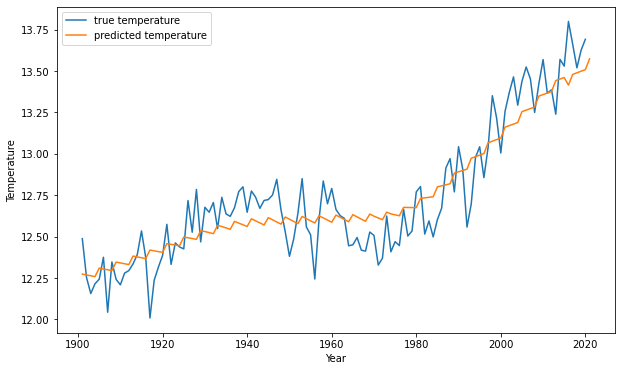

In [42]:
# plot true vs predicted
plt.figure(figsize=(10,6))
sns.lineplot(x='Year', y='Temperature', data=merged, ci=None, markers=True, label='true temperature')
sns.lineplot(x='ds', y='Temperature', data=mdf, ci=None, markers=True, label='predicted temperature')
plt.legend()
plt.show()

#### check errors

In [43]:
mae = mean_absolute_error(test['Temperature'], predicted['Temperature'])
r2 = r2_score(test['Temperature'], predicted['Temperature'])
print("Temperature")
print("mae: ", mae)
print("r2: ", r2)

Temperature
mae:  0.38907537157527144
r2:  0.9983425836268115


In [44]:
mae = mean_absolute_error(test['Precipitation'], predicted['Precipitation'])
r2 = r2_score(test['Precipitation'], predicted['Precipitation'])
print("Precipitation")
print("mae: ", mae)
print("r2: ", r2)

Precipitation
mae:  61.13223258460428
r2:  0.9681574335110595


### Forecast for the next 100 years

In [45]:
# train and forecast on the whole dataset
predicted = pd.DataFrame()
cols = ['Temperature', 'Precipitation']

for country in grouped.groups:
    c = grouped.get_group(country)
    for col in cols:
        temp = c.rename(columns={"Year": "ds", 'Country': "Country", col:'y'})
        
        m = Prophet()
        # train model
        m.fit(temp)
        # make forecast for next years
        future = m.make_future_dataframe(periods=100, freq='Y')
        forecast = m.predict(future)
        #     m.plot(forecast)
        # rename column , so it won't be ovewriten by next city
        forecast = forecast.rename(columns={'yhat': f'{country}_{col}'})
        predicted = pd.merge(predicted, forecast.set_index('ds')[f'{country}_{col}'], how='outer', left_index=True, right_index=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [46]:
predicted

,Algeria_Temperature,Algeria_Precipitation,Argentina_Temperature,Argentina_Precipitation,Australia_Temperature,Australia_Precipitation,Bangladesh_Temperature,Bangladesh_Precipitation,Brazil_Temperature,Brazil_Precipitation,Canada_Temperature,Canada_Precipitation,Central African Republic_Temperature,Central African Republic_Precipitation,China_Temperature,China_Precipitation,Egypt_Temperature,Egypt_Precipitation,France_Temperature,France_Precipitation,Greenland_Temperature,Greenland_Precipitation,Iceland_Temperature,Iceland_Precipitation,India_Temperature,India_Precipitation,Russia_Temperature,Russia_Precipitation,Saudi Arabia_Temperature,Saudi Arabia_Precipitation,United Kingdom_Temperature,United Kingdom_Precipitation,United States_Temperature,United States_Precipitation
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1901-01-01,22.482442,80.895381,14.505794,497.579278,21.468176,440.732123,24.852356,2534.977856,25.051010,1744.483270,-5.724774,515.090980,24.793541,1336.165145,6.421733,594.842060,21.639830,38.726737,10.213737,814.376033,-17.444413,570.777998,1.328867,848.197885,24.053022,1060.511339,-5.836568,425.515199,24.239172,78.184769,8.147174,1067.656010,8.422950,669.678467
1902-01-01,22.466173,82.223378,14.441652,499.171494,21.443983,441.368903,24.883771,2535.678731,25.020457,1737.545570,-5.731482,514.664285,24.778892,1336.789525,6.404843,594.666160,21.679108,38.526201,10.217012,822.060881,-17.403566,575.149705,1.338870,845.049256,24.065576,1057.045904,-5.802988,424.863198,24.237439,78.169774,8.133389,1091.392496,8.390537,665.505539
1903-01-01,22.449003,83.564643,14.377891,500.724493,21.419771,441.997163,24.915141,2536.296268,24.988927,1730.630243,-5.737886,514.239773,24.764232,1337.424521,6.387912,594.466859,21.718278,38.328422,10.219839,829.739342,-17.362058,579.569070,1.349048,841.946051,24.078234,1053.508526,-5.769134,424.200901,24.235730,78.154600,8.119559,1115.066749,8.358080,661.309116
1904-01-01,22.430955,84.917475,14.314591,502.237506,21.395566,442.616685,24.946441,2536.826575,24.956440,1723.746107,-5.743965,513.817085,24.749587,1338.071294,6.370968,594.244584,21.757332,38.133569,10.222223,837.402211,-17.319897,584.030738,1.359398,838.895503,24.090986,1049.904078,-5.735037,423.529695,24.234063,78.139234,8.105709,1138.650695,8.325632,657.094783
1905-01-01,22.485170,80.667947,14.510260,501.260185,21.465024,442.526454,24.895476,2524.652598,24.983401,1745.813048,-5.677902,512.216809,24.816911,1342.525255,6.447886,595.446920,21.776475,38.491828,10.245363,814.823141,-17.307092,570.841266,1.359636,859.567567,24.068762,1062.385568,-5.798277,427.430196,24.296482,78.084002,8.170766,1070.053641,8.467977,671.262997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115-12-31,25.208468,84.352210,15.468832,698.322244,23.854877,538.440080,26.464592,2000.437530,28.415091,1660.073629,-2.757879,529.766395,27.261363,1308.416910,10.161773,622.793001,27.408108,25.040246,15.452805,919.863795,-11.204533,739.109643,3.019589,1391.640087,26.863974,1022.835232,-0.245170,505.847905,29.670261,72.829856,11.057666,1514.996639,11.969628,755.201177
2116-12-31,25.299488,79.970521,15.656497,698.339087,23.939931,538.572874,26.413250,1990.592727,28.507391,1680.057086,-2.697097,528.818173,27.339809,1310.601745,10.256983,624.505605,27.435563,25.316940,15.513023,898.421504,-11.199178,726.038222,3.016022,1410.433958,26.854197,1035.977461,-0.288648,509.828067,29.754848,72.779887,11.135061,1451.360317,12.122522,769.646919
2117-12-31,25.294570,81.356455,15.607026,699.581829,23.934517,539.133797,26.439535,1990.462360,28.513757,1672.933225,-2.696538,529.062635,27.339282,1309.454955,10.260897,624.157867,27.478922,25.144841,15.539967,905.799630,-11.146098,731.309787,3.027350,1407.819149,26.881031,1031.557420,-0.230726,509.117545,29.778638,72.762851,11.135403,1474.302336,12.106428,765.761613


In [47]:
# convert df the right format
df = predicted.copy()
df.columns = df.columns.str.split('_', expand=True)
df = df.rename_axis((None, 'measure'), axis=1).stack().reset_index()
dff = df.melt(id_vars=['ds', 'measure'], var_name='Country')

grouped_dff = dff.groupby(["measure"])
t_df = grouped_dff.get_group("Temperature")
p_df = grouped_dff.get_group("Precipitation") 

t_df.drop(columns=['measure'], inplace=True)
t_df.rename(columns={'value': 'Temperature'}, inplace=True)
p_df.drop(columns=['measure'], inplace=True)
p_df.rename(columns={'value': 'Precipitation'}, inplace=True)

predicted_merged = t_df.merge(p_df, how='inner', on=['ds', 'Country'])
predicted_merged.rename(columns={"ds": "Year"}, inplace=True)
predicted_merged.head()

C:\Users\tigju\Anaconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\tigju\Anaconda3\envs\datascience\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Year,Country,Temperature,Precipitation
0,1901-01-01,Algeria,22.482442,80.895381
1,1902-01-01,Algeria,22.466173,82.223378
2,1903-01-01,Algeria,22.449003,83.564643
3,1904-01-01,Algeria,22.430955,84.917475
4,1905-01-01,Algeria,22.485170,80.667947


In [48]:
predicted_merged.to_csv("projection_100.csv")

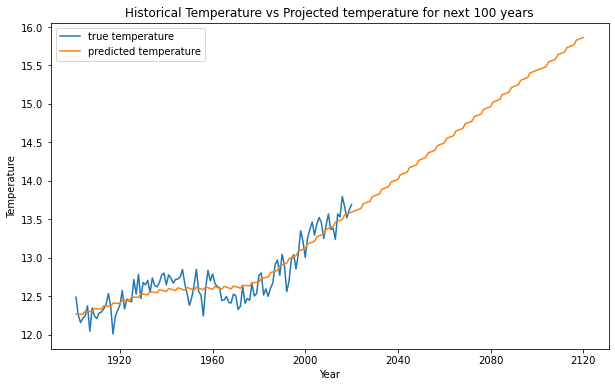

In [49]:
# plot true vs predicted
plt.figure(figsize=(10,6))
sns.lineplot(x='Year', y='Temperature', data=merged, ci=None, markers=True, label='true temperature')
sns.lineplot(x='Year', y='Temperature', data=predicted_merged, ci=None, markers=True, label='predicted temperature')
plt.legend()
plt.title("Historical Temperature vs Projected temperature for next 100 years")
plt.show()

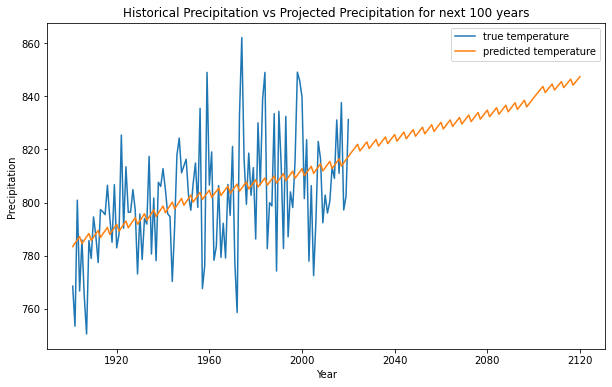

In [50]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Year', y='Precipitation', data=merged, ci=None, markers=True, label='true temperature')
sns.lineplot(x='Year', y='Precipitation', data=predicted_merged, ci=None, markers=True, label='predicted temperature')
plt.legend()
plt.title("Historical Precipitation vs Projected Precipitation for next 100 years")
plt.show()